# Исследование тарифов сотовой связи <br>федерального оператора «Мегалайн» <a id="заголовок"></a>

## Оглавление <a id="оглавление"></a>

* [Описание проекта](#описание)
* [Шаг 1. Изучение данных](#Шаг_1)
* [Шаг 2. Предобработка данных](#Шаг_2)
* [Шаг 3. Анализ данных](#Шаг_3)
* [Шаг 4. Проверка гипотез](#Шаг_4)
* [Шаг 5. выводы по итогам исследования](#Шаг_5)

## Описание проекта <a id="описание"></a>

**Заказчик:** «Мегалайн» — федеральный оператор сотовой связи

**Продукт:** сотовая связь по двум тарифам: «Смарт» и «Ультра»

**Цель:** скорректировать рекламный бюджет продуктов

**Задача**: определить, какой тариф приносит больше денег (проанализировать тарифы на небольшой выборке клиентов)

**Данные:** данные 500 пользователей оператора: личные, о тарифах, звонках, использовании интернета и расходах по каждой категории

**Важные замечания:**
1. «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута
2. Длительность многих звонков — 0.0 минут. Это могут быть пропущенные звонки.

### Описание продукта

#### Тариф «Смарт»
* **Ежемесячная плата:** 550 рублей <br>
* **Включено:** 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика <br>
* **Стоимость услуг сверх тарифного пакета:** <br>
* **минута разговора:** 3 рубля <br>
* **сообщение:** 3 рубля <br>
* **1 Гб интернет-трафика:** 200 рублей <br>


#### Тариф «Ультра»
* **Ежемесячная плата:** 1950 рублей <br>
* **Включено:** 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика <br>
* **Стоимость услуг сверх тарифного пакета:** <br>
* **минута разговора:** 1 рубль <br>
* **сообщение:** 1 рубль <br>
* **1 Гб интернет-трафика:** 150 рублей <br>

## Шаг 1. Изучение данных <a id="Шаг_1"></a>

[В начало проекта](#заголовок) <br>
[К выводам по шагу](#conclusion1)

In [1]:
# импортируем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import math as mt

import warnings # возникали предупреждения, но код работал
warnings.filterwarnings('ignore') # решил отключить эти предупреждения

pd.options.display.float_format = '{: .2f}'.format

calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col=0)
messages = pd.read_csv('/datasets/messages.csv') 
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

### Таблица calls (информация о звонках; 4 столбца):
1. id — уникальный номер звонка
2. call_date — дата звонка
3. duration — длительность звонка в минутах
4. **user_id** — идентификатор пользователя, сделавшего звонок

In [2]:
calls.info()
calls.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Нужно заменить тип данных в столбце с датой на временной тип. <br>
Таблица не содержит пропусков. <br>

### Таблица internet (информация об интернет-сессиях; 13 столбцов):
1. id — уникальный номер сессии
2. mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
3. session_date — дата интернет-сессии
4. **user_id** — идентификатор пользователя
5. Таблица tariffs (информация о тарифах):
6. tariff_name — название тарифа
7. rub_monthly_fee — ежемесячная абонентская плата в рублях
8. minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
9. messages_included — количество сообщений в месяц, включённых в абонентскую плату
10. mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
11. rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
12. rub_per_message — стоимость отправки сообщения сверх тарифного пакета
13. rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [3]:
internet.info()
internet.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


,id,mb_used,session_date,user_id
2364,1009_6,236.79,2018-06-27,1009
93126,1314_480,224.00,2018-07-25,1314
77476,1262_128,368.90,2018-03-17,1262
7966,1027_293,237.66,2018-11-10,1027
142404,1477_301,223.02,2018-12-21,1477


В таблице internet есть столбец без названия, в котором дублируются значения индекса строк. Его нужно будет удалить. <br>
Таблица содержит нулевые значения в столбце mb_used. Нужно будет изучить их. <br>
Также нужно заменить тип данных в столбце с датой на временной тип. <br>
Таблица не содержит пропусков. <br>

### Таблица messages (информация о сообщениях; 3 столбца):
1. id — уникальный номер сообщения
2. message_date — дата сообщения
3. **user_id** — идентификатор пользователя, отправившего сообщение

In [4]:
messages.info()
messages.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
85241,1356_258,2018-10-29,1356
57791,1253_300,2018-10-02,1253
30929,1134_647,2018-11-17,1134
41840,1178_63,2018-12-03,1178
9237,1035_472,2018-09-06,1035


Таблица не содержит пропусков. <br>
Также нужно будет заменить тип данных в столбце message_date.

### Таблица tariffs (информация о тарифах):
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [5]:
tariffs.info()
tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица в порядке.

### Таблица users (информация о пользователях; 8 столбцов):
1. **user_id** — уникальный идентификатор пользователя
2. first_name — имя пользователя
3. last_name — фамилия пользователя
4. age — возраст пользователя (годы)
5. reg_date — дата подключения тарифа (день, месяц, год)
6. churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
7. city — город проживания пользователя
8. tariff — название тарифного плана

In [6]:
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [7]:
# сразу же изучим, сколько пропущенных значений в столбце churn_date
print('Пропущено {:.1%}'. format(users.churn_date.isna().value_counts()[1] / len(users), 2) + ' значений в столбце churn_date')

Пропущено 92.4% значений в столбце churn_date


В таблице 'users' пропуски есть только в столбце 'churn_date',которые содержит дату ухода клиента, и при этом пропущено 92% от всех значений. <br>
Скорее всего наличие пропусков обосновано: это те клиенты, которые не прекратили обслуживаться у оператора.<br>

Следует заменить тип данных в столбцах reg_date и churn_date.

### Выводы <a id="conclusion1"></a>

Все таблицы (кроме tariffs) связаны между собой по столбцу user_id.

Во всех таблицах, кроме таблицы 'users', нет пропущенных значений. <br>
Почти во всех таблицах есть столбцы с неправильным типом данных. <br>

Тип данных заменим в следующих столбцах: <br>
* call_date в таблице calls
* session_date в таблице internet (а также удалить лишний столбец)
* message_date в таблице messages
* reg_date в таблице users

***

## Шаг 2. Предобработка данных <a id="Шаг_2"></a>

[В начало проекта](#заголовок) <br>
[К выводам по шагу](#conclusion2)

### Изменение типов данных

In [9]:
# заменим типы данных в столбцах с датами у разных таблиц

calls.call_date = pd.to_datetime(calls.call_date, format='%Y.%m.%d')
internet.session_date = pd.to_datetime(internet.session_date, format='%Y.%m.%d')
messages.message_date = pd.to_datetime(messages.message_date, format='%Y.%m.%d')
users.reg_date = pd.to_datetime(users.reg_date, format='%Y.%m.%d')
users.churn_date = pd.to_datetime(users.churn_date, format='%Y.%m.%d')

# проверяем
print(calls.call_date.dtypes)
print(internet.session_date.dtypes)
print(messages.message_date.dtypes)
print(users.reg_date.dtypes)

# ниже видим, что типы данных изменились

datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]


### Округление значений
Важно помнить, что оператор округляет продолжительность звонков до минут и объем интернет-трафика до мегабайт.<br>
Округлим значения в этих столбцах прежде, чем приступать к очистке и анализу. <br>
[В начало шага](#Шаг_2)

***

In [10]:
# округлим продолжительность звонках в минутах до целых значений вверх и заменим тип данных на целочисленный
calls.duration = np.ceil(calls.duration).astype(int)
calls.sample(3)

,id,call_date,duration,user_id
110674,1284_272,2018-10-06,4,1284
152048,1379_283,2018-09-06,9,1379
130977,1335_454,2018-08-16,6,1335


In [11]:
# округлим кол-во мегабайт в сессиях до целых значений вверх и заменим тип данных на целочисленный
internet.mb_used = np.ceil(internet.mb_used).astype(int)
internet.sample(3)

,id,mb_used,session_date,user_id
95881,1324_75,189,2018-10-07,1324
117902,1395_586,477,2018-05-18,1395
119549,1403_104,388,2018-07-23,1403


### Очистка данных
Очищаем данные от нелогичных и экстремальных значений <br>
[В начало шага](#Шаг_2) <br>

*Обратите внимание, что длительность многих звонков — 0.0 минут. Это могут быть пропущенные звонки. Обрабатывать ли эти нулевые значения, решать вам — оцените, как их отсутствие повлияет на результаты анализа.*

In [12]:
#изучим таблицы, по которым будем делать рассчеты, чтобы найти нелогичные или экстремальные значения

tables_to_describe = [calls, internet, messages, users]

for table in tables_to_describe:
    display(table.describe())

,duration,user_id
count,202607.00,202607.00
mean,7.16,1253.94
std,5.96,144.72
min,0.00,1000.00
25%,2.00,1126.00
50%,6.00,1260.00
75%,11.00,1379.00
max,38.00,1499.00


,mb_used,user_id
count,149396.00,149396.00
mean,370.62,1252.10
std,278.39,144.05
min,0.00,1000.00
25%,139.00,1130.00
50%,349.00,1251.00
75%,560.00,1380.00
max,1725.00,1499.00


,user_id
count,123036.00
mean,1256.99
std,143.52
min,1000.00
25%,1134.00
50%,1271.00
75%,1381.00
max,1499.00


,user_id,age
count,500.00,500.00
mean,1249.50,46.59
std,144.48,16.67
min,1000.00,18.00
25%,1124.75,32.00
50%,1249.50,46.00
75%,1374.25,62.00
max,1499.00,75.00


На первый взгляд описание таблиц выглядит адекватно. <br>
Но стоит отдельно изучить распределение длительности звонков и использования мегабайт.

#### Изучаем звонки

In [13]:
# отдельно проверим распределение данных в продолжительности звонка и кол-ве мегабайт

# напишем функцию для построения гистограм, которая еще пригодится по ходу проекта
# функция будет принимать на вход название таблицы, вид гистограммы, данные для расположения на оси Х и название гистограммы

def buildhist(data, kind, xlabel, title):
    plt.figure(figsize=(10,3))
    data.plot(kind = kind, alpha=0.5)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

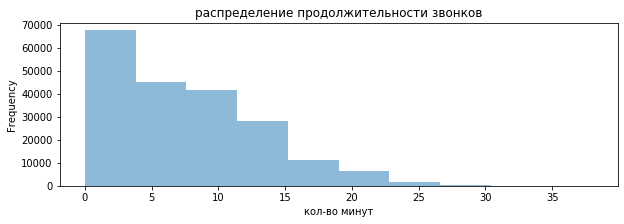

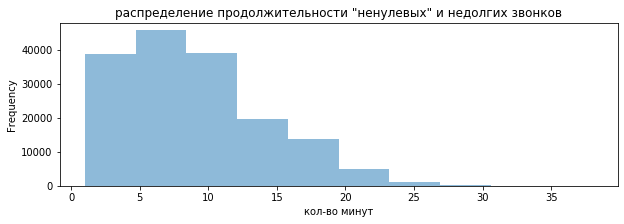

Доля звонков с нулевой продолжительностью: 19.6%


In [14]:
# построим гистограмму продолжительности звонков
buildhist(calls.duration, 'hist', 'кол-во минут', 'распределение продолжительности звонков')

#построим гистограмму ненулевых звонков
buildhist(calls.query('0 < duration').duration, 'hist', 'кол-во минут', 'распределение продолжительности "ненулевых" и недолгих звонков')

print('Доля звонков с нулевой продолжительностью: {:.1%}'
      .format(calls.query('duration == 0')['duration'].value_counts()[0] / len(calls)))

Вид распределения меняется, если удалить нулевые звонки. <br>
Значит, изменятся и значения среднего. <br>
Проверим.

In [15]:
#посмотрим, как меняются средние значения в столбце duration, если избавиться от крайних значений
# крайними значениями будем считать значения выше 27 минут

print()
print('среднее, медиана и ст. откл. в сырых данных')
display(calls.agg({'duration': ['mean', 'median', 'std']}))
print()
print()
print('среднее, медиана и ст. откл. в данных без нулевых звонков')
display(calls.query('0 < duration').agg({'duration': ['mean', 'median', 'std']}))
print()
print()
print('среднее, медиана и ст. откл. в данных без нулевых и слишком долгих звонков')
display(calls.query('0 < duration <= 27').agg({'duration': ['mean', 'median', 'std']}))


среднее, медиана и ст. откл. в сырых данных


,duration
mean,7.16
median,6.00
std,5.96




среднее, медиана и ст. откл. в данных без нулевых звонков


,duration
mean,8.90
median,8.00
std,5.35




среднее, медиана и ст. откл. в данных без нулевых и слишком долгих звонков


,duration
mean,8.86
median,8.00
std,5.29


При удалении нулевых звонков видно, что среднее и медиана увеличиваются почти на 2 минуты. <br>
Это повлияет на расчет средних значений по тарифам. <br>
А вот удаление слишком длинных звонков практически не влияет на среднее и медианное значения продолжительности звонков. <br>
К тому же наличие звонков дольше 25 минут не выглядит нелогичным: некоторые люди любят долго разговаривать. <br>
Такие значения удалять не будем.

Доля нулевых звонков достаточно большая, почти 20%. <br>
Замена нулей на медианные значения может привести к сильному искажению данных. <br>
Поэтому будем считать такие звонки пропущенными и удалим их из таблицы, чтобы они не искажали результаты исследования.

In [16]:
# обновим таблицу
calls = calls.query('duration > 0')
calls.duration.describe()

count    162994.00
mean          8.90
std           5.35
min           1.00
25%           5.00
50%           8.00
75%          12.00
max          38.00
Name: duration, dtype: float64

#### Изучаем интернет-трафик

В столбце mb_used таблицы internet тоже есть нулевые значения, которые могут влиять на расчеты среднего. <br>
Также в нем есть несколько очень больших значений. <br>
Изучим, как удаление крайних значений влияет на значение среднего и медианы.

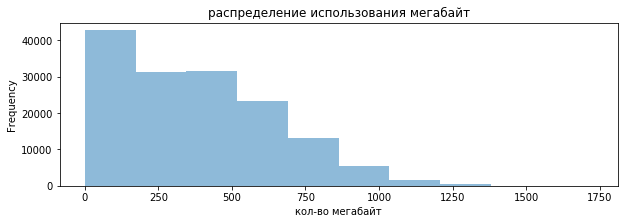

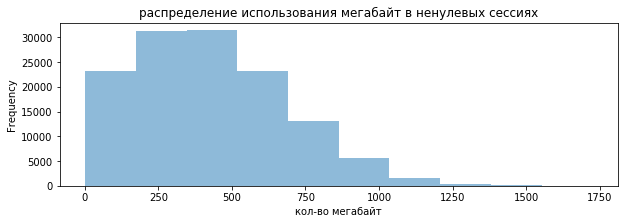

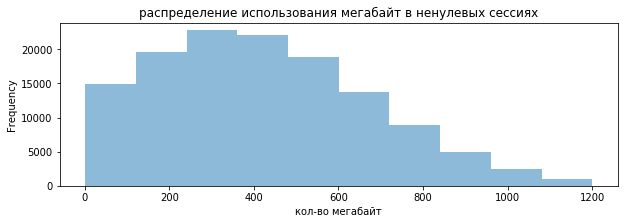

Доля нулевых интернет сессий: 13.1%
Доля слишком больших сессий: 0.3%


In [17]:
#построим гистограмму использования мегабайт

# для сырых данных
buildhist(internet.mb_used, 'hist', 'кол-во мегабайт', 'распределение использования мегабайт')

# для ненулевых сессий
buildhist(internet.query('mb_used > 0').mb_used, 'hist', 'кол-во мегабайт', 'распределение использования мегабайт в ненулевых сессиях')

# для ненулевых сессий и не слишком больших сессий
buildhist(internet.query('0< mb_used <= 1200').mb_used, 'hist', 'кол-во мегабайт', 'распределение использования мегабайт в ненулевых сессиях')

# посчитаем доли крайних значений
print('Доля нулевых интернет сессий: {:.1%}'
      .format(internet.query('mb_used == 0')['mb_used'].value_counts()[0] / len(internet)))

print('Доля слишком больших сессий: {:.1%}'
      .format(internet.query('mb_used > 1200')['mb_used'].count() / len(internet)))

In [18]:
#посмотрим, как меняются средние значения в столбце duration, если избавиться от крайних значений
# крайними значениями будем считать значения выше 1200 мегабайт

print()
print('среднее, медиана и ст. откл. в сырых данных')
display(internet.agg({'mb_used': ['mean', 'median', 'std']}))
print()
print('среднее, медиана и ст. откл. в ненулевых сессиях')
display(internet.query('0 < mb_used').agg({'mb_used': ['mean', 'median', 'std']}))
print()
print('среднее, медиана и ст. откл. в ненулевых сессиях и сессиях до 1200мб')
display(internet.query('0 < mb_used <= 1200').agg({'mb_used': ['mean', 'median', 'std']}))


среднее, медиана и ст. откл. в сырых данных


,mb_used
mean,370.62
median,349.00
std,278.39



среднее, медиана и ст. откл. в ненулевых сессиях


,mb_used
mean,426.58
median,401.00
std,255.60



среднее, медиана и ст. откл. в ненулевых сессиях и сессиях до 1200мб


,mb_used
mean,423.24
median,400.00
std,250.22


Сессиями с использованием 0мб могут быть сессии, в которых кол-во мегабайт не учитывается в общем расходе. <br>
Например, мноиге оперататоры предоставляют доступ к тем или иным сайтам и приложениям на безлимитной основе за доп. плату. <br>
Тем не менее общий объем таких нулевых сессий влияет на средний объем сессии. Удалим такие значения. <br>
Также в таблице есть очень мало слишком объемных сессий. Они тоже влияют на расчет средних значений и их мы тоже удалим.

In [19]:
# удалим ненужные значения из таблицы

internet = internet.query('0 < mb_used <= 1200')
internet.mb_used.describe()

count    129304.00
mean        423.24
std         250.22
min           1.00
25%         227.00
50%         400.00
75%         591.00
max        1200.00
Name: mb_used, dtype: float64

### Итоги предобработки
[В начало шага](#Шаг_2)

Во всех таблицах исправили написание id и привели этот столбец к целочисленному типу данных. <br>
Столбцы с датами привели к временному типу. <br>
Округлили значения продолжительности звонков и объема интернет-сессий в мегабайтах до верхних значений и привели к целочиленному типу. <br>

В таблице calls удалили звонки с продолжительностью 0, так как они могут повлиять на результаты анализа. <br>
В таблице internet удалили сессии с 0мб, а также сессии свыше 1200мб, так как они влияют на расчет средних значений.

***

### Построение отчета по пользователям

[В начало шага](#Шаг_2)

Для каждого пользователя посчитать:
- [x] кол-во сделанных звонков по месяцам
- [x] кол-во израсходованных минут разговора по месяцам
- [x] кол-во отправленных сообщений по месяцам
- [x] объем израсходованного интернет-трафика по месяцам
- [x] помесячную выручку с каждого пользователя

*для расчета выручки вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану)*

In [20]:
# создадим таблицу с 12 месяцами

min_month = calls['call_date'].values.astype('datetime64[M]').min()
max_month = calls['call_date'].values.astype('datetime64[M]').max()

months = pd.DataFrame(pd.date_range(min_month,max_month,freq='MS'))
months.columns = ['month']
months

,month
0,2018-01-01
1,2018-02-01
2,2018-03-01
3,2018-04-01
4,2018-05-01
5,2018-06-01
6,2018-07-01
7,2018-08-01
8,2018-09-01
9,2018-10-01


In [21]:
# чтобы получить отчет по каждому пользователю за каждый месяц, нужно сделать кроссджоин
# таким образом в каждом месяце будут все клиенты
# должна получиться таблица следующей длины

len(users) * len(months)

6000

In [22]:
# чтобы сделать кросс-джоин, добавим в таблицу с пользователями и месяцами общий ключ
# пусть это будет 1
users['key'] = 1
months['key'] = 1

# далее джойним таблицы по ключу
report = months.merge(users,on='key')

# заменим тип данных в новом столбце на временной
report.month = pd.to_datetime(report.month, format='%Y.%m.%d')

# проверяем
report # все верно: 6000 строк

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,2018-01-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,2018-01-01,1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,2018-01-01,1,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,2018-01-01,1,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,2018-01-01,1,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...,...,...
5995,2018-12-01,1,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra
5996,2018-12-01,1,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart
5997,2018-12-01,1,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart
5998,2018-12-01,1,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


Важно помнить, что в таблице users указаны дата регистрации пользователя и дата его ухода. <br>
Значит, по некоторым пользователям не будет данных в определенные месяцы: не будет данных раньше даты регистрации и позже даты ухода. <br>

Из-за наличия пропущенных значений в столбце churn_date сделать срез по логическому условию неудобно: нельзя сравнить дату в колонке month с пропущенными значениями в churn_date. <br>

Поэтому сначала сделаем необходимые расчеты, а потом удалим строки, у которых в столбцах с кол-вом звонков, смс и МБ будут пропуски. <br>
Так мы удалим строки с теми месяцами, в которых конкретные пользователи еще не зарегистрировались или уже ушли.

#### Считаем кол-во звонков у пользователей за каждый месяц

In [23]:
# в таблице calls создаем столбец с месяцем звонка, чтобы сделать по нему группировку
calls['month'] = calls['call_date'].values.astype('datetime64[M]')

# делаем группировку по каждому пользователю и месяцу
calls_month = calls.groupby(['month','user_id'])['call_date'].count().reset_index()
calls_month.columns = ['month','user_id','calls']
display(calls_month.head(5))

# проверяем итоговое кол-во звонков в новой таблице
# найдем отношение кол-ва звонков из новой таблицы к колву звонков в таблице calls
print('соотношение новых значений к изначальным:', (calls_month.calls.sum() / calls.call_date.count()))

# если количество звонков одинаковое, получим соотношение 1:1
# общее кол-во звонков получилось таким же

,month,user_id,calls
0,2018-01-01,1005,11
1,2018-01-01,1032,44
2,2018-01-01,1045,1
3,2018-01-01,1055,47
4,2018-01-01,1071,18


соотношение новых значений к изначальным: 1.0


#### Считаем кол-во минут у пользователей за каждый месяц

In [24]:
calls['month'] = calls['call_date'].values.astype('datetime64[M]')

minutes_month = calls.groupby(['month','user_id'])['duration'].sum().reset_index()
minutes_month.columns = ['month','user_id','minutes']

display(minutes_month.head(5))
print('соотношение новых значений к изначальным:', (minutes_month.minutes.sum() / calls.duration.sum()))

,month,user_id,minutes
0,2018-01-01,1005,95
1,2018-01-01,1032,380
2,2018-01-01,1045,9
3,2018-01-01,1055,551
4,2018-01-01,1071,194


соотношение новых значений к изначальным: 1.0


#### Считаем кол-во сообщений у пользователей за каждый месяц

In [25]:
messages['month'] = messages['message_date'].values.astype('datetime64[M]')

messages_month = messages.groupby(['month','user_id'])['message_date'].count().reset_index()
messages_month.columns = ['month','user_id','messages']

display(messages_month.head(5))
print('соотношение новых значений к изначальным:', (messages_month.messages.sum() / messages.message_date.count()))

,month,user_id,messages
0,2018-01-01,1005,7
1,2018-01-01,1032,38
2,2018-01-01,1045,5
3,2018-01-01,1055,30
4,2018-01-01,1071,16


соотношение новых значений к изначальным: 1.0


#### Считаем объем трафика у пользователей за каждый месяц

In [26]:
internet['month'] = internet['session_date'].values.astype('datetime64[M]')

internet_month = internet.groupby(['month','user_id'])['mb_used'].sum().reset_index()
internet_month.columns = ['month','user_id','mb_used']

display(internet_month.head(5))
print('соотношение новых значений к изначальным:', (internet_month.mb_used.sum() / internet.mb_used.sum()))


,month,user_id,mb_used
0,2018-01-01,1005,2730
1,2018-01-01,1032,24147
2,2018-01-01,1045,2348
3,2018-01-01,1055,17111
4,2018-01-01,1071,15622


соотношение новых значений к изначальным: 1.0


#### Соединяем таблицы

In [27]:
report = report.merge(calls_month,how='left',on=['user_id','month'])
report = report.merge(minutes_month,how='left',on=['user_id','month'])
report = report.merge(messages_month,how='left',on=['user_id','month'])
report = report.merge(internet_month,how='left',on=['user_id','month'])
report
#осторожно: если выполнять код, то с каждым выполнением будут добавляться 3 столбца с суффиксами

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,calls,minutes,messages,mb_used
0,2018-01-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,nan,nan,nan,nan
1,2018-01-01,1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,nan,nan,nan,nan
2,2018-01-01,1,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,nan,nan,nan,nan
3,2018-01-01,1,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,nan,nan,nan,nan
4,2018-01-01,1,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,2018-12-01,1,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra,120.00,1031.00,84.00,23450.00
5996,2018-12-01,1,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart,65.00,518.00,51.00,20757.00
5997,2018-12-01,1,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart,58.00,545.00,17.00,19940.00
5998,2018-12-01,1,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,nan,nan,nan,nan


In [28]:
# ранее мы установили, что в определенные месяцы не будет данных для пользователей,
# которые на этот месяц еще не зарегистрировались или уже ушли от оператора

# проверим
report.query('calls.isna() & minutes.isna() & messages.isna() & mb_used.isna()')

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,calls,minutes,messages,mb_used
0,2018-01-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,nan,nan,nan,nan
1,2018-01-01,1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,nan,nan,nan,nan
2,2018-01-01,1,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,nan,nan,nan,nan
3,2018-01-01,1,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,nan,nan,nan,nan
4,2018-01-01,1,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,2018-12-01,1,1370,48,2018-10-27,Новороссийск,Гектор,Сысоев,2018-02-06,smart,nan,nan,nan,nan
5871,2018-12-01,1,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,nan,nan,nan,nan
5892,2018-12-01,1,1392,54,2018-09-27,Челябинск,Алла,Беликова,2018-02-27,ultra,nan,nan,nan,nan
5980,2018-12-01,1,1480,29,2018-09-26,Новокузнецк,Гелена,Емельянова,2018-02-14,smart,nan,nan,nan,nan


In [29]:
# так и оказалось: в первых строках в Январе нет данных для тех, кто зарегистировлся позже января
# аналогично в последних строках в Декабре нет данных для тех, кто ушел раньше декабря

# обновим отчет

#посчитаем, сколько строк должно получиться:
display(len(report) - len(report.query('calls.isna() & minutes.isna() & messages.isna() & mb_used.isna()')))

report = report.query('~(calls.isna() & minutes.isna() & messages.isna() & mb_used.isna())').reset_index()
report

3214

,index,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,calls,minutes,messages,mb_used
0,5,2018-01-01,1,1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,11.00,95.00,7.00,2730.00
1,32,2018-01-01,1,1032,31,NaT,Ульяновск,Инна,Игнатьева,2018-01-04,smart,44.00,380.00,38.00,24147.00
2,45,2018-01-01,1,1045,48,NaT,Улан-Удэ,Джемма,Карасева,2018-01-30,smart,1.00,9.00,5.00,2348.00
3,55,2018-01-01,1,1055,39,NaT,Казань,Луиза,Березина,2018-01-02,smart,47.00,551.00,30.00,17111.00
4,71,2018-01-01,1,1071,20,2018-08-31,Омск,Гектор,Чумаков,2018-01-09,smart,18.00,194.00,16.00,15622.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,5994,2018-12-01,1,1494,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart,54.00,418.00,nan,17645.00
3210,5995,2018-12-01,1,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra,120.00,1031.00,84.00,23450.00
3211,5996,2018-12-01,1,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart,65.00,518.00,51.00,20757.00
3212,5997,2018-12-01,1,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart,58.00,545.00,17.00,19940.00


In [30]:
# Важно заметить, что некоторые абоненты могут не звонить, не выходить в интернет или не писать смс
# у таких клиентов в соответствующих столбцах будут пропуски
# заменим их на 0 значения

report = report.fillna(0)

report.sort_values(by = 'calls').head(5)

,index,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,calls,minutes,messages,mb_used
2494,5231,2018-11-01,1,1231,63,0,Чебоксары,Касьян,Авдюков,2018-05-23,ultra,0.00,0.00,173.00,27459.00
446,2091,2018-05-01,1,1091,36,0,Набережные Челны,Вера,Суслова,2018-05-08,ultra,0.00,0.00,30.00,10714.00
1850,4473,2018-09-01,1,1473,18,0,Красноярск,Николай,Лебедев,2018-08-05,ultra,0.00,0.00,19.00,17307.00
928,3106,2018-07-01,1,1106,67,0,Калуга,Исаак,Костин,2018-04-26,ultra,0.00,0.00,24.00,20210.00
1558,4091,2018-09-01,1,1091,36,0,Набережные Челны,Вера,Суслова,2018-05-08,ultra,0.00,0.00,32.00,13945.00


In [31]:
# все верно - получили нужное кол-во строк; остались только строки, в которых удалось посчитать кол-во звонков, сообщений и МБ

# теперь удалим лишние столбцы из отчета
report = report[['month', 'user_id', 'city', 'tariff', 'calls', 'minutes', 'messages', 'mb_used']]

# заменим тип данных на целочисленный
report['calls'] = report['calls'].astype(int)
report['minutes'] = report['minutes'].astype(int)
report['messages'] = report['messages'].astype(int)
report['mb_used'] = report['mb_used'].astype(int)
# изменим тип данных на целочисленный
display(report)

display(tariffs)

,month,user_id,city,tariff,calls,minutes,messages,mb_used
0,2018-01-01,1005,Набережные Челны,smart,11,95,7,2730
1,2018-01-01,1032,Ульяновск,smart,44,380,38,24147
2,2018-01-01,1045,Улан-Удэ,smart,1,9,5,2348
3,2018-01-01,1055,Казань,smart,47,551,30,17111
4,2018-01-01,1071,Омск,smart,18,194,16,15622
...,...,...,...,...,...,...,...,...
3209,2018-12-01,1494,Омск,smart,54,418,0,17645
3210,2018-12-01,1495,Иркутск,ultra,120,1031,84,23450
3211,2018-12-01,1496,Вологда,smart,65,518,51,20757
3212,2018-12-01,1497,Челябинск,smart,58,545,17,19940


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


#### Считаем выручку по пользователям за каждый месяц

In [32]:
# в таблицу с отчетом добавим столбцы с информацией о тарифе для каждого клиента

report = report.merge(tariffs, how='left', left_on='tariff', right_on='tariff_name')

report

,month,user_id,city,tariff,calls,minutes,messages,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,2018-01-01,1005,Набережные Челны,smart,11,95,7,2730,50,15360,500,550,200,3,3,smart
1,2018-01-01,1032,Ульяновск,smart,44,380,38,24147,50,15360,500,550,200,3,3,smart
2,2018-01-01,1045,Улан-Удэ,smart,1,9,5,2348,50,15360,500,550,200,3,3,smart
3,2018-01-01,1055,Казань,smart,47,551,30,17111,50,15360,500,550,200,3,3,smart
4,2018-01-01,1071,Омск,smart,18,194,16,15622,50,15360,500,550,200,3,3,smart
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,2018-12-01,1494,Омск,smart,54,418,0,17645,50,15360,500,550,200,3,3,smart
3210,2018-12-01,1495,Иркутск,ultra,120,1031,84,23450,1000,30720,3000,1950,150,1,1,ultra
3211,2018-12-01,1496,Вологда,smart,65,518,51,20757,50,15360,500,550,200,3,3,smart
3212,2018-12-01,1497,Челябинск,smart,58,545,17,19940,50,15360,500,550,200,3,3,smart


In [33]:
# создадим новый столбцы, которые будут содержать стоимость потраченных сверх тарифа минут, сообщений и мегабайт
# нулевые значения пригодятся, если окажется, что клиент не превышал лимиты

report['minutes_extra_pay'] = 0
report['messages_extra_pay'] = 0
report['mb_extra_pay'] = 0

In [34]:
report.loc[report['minutes'] > report['minutes_included'], 'minutes_extra_pay'] = (
                                                                           (report['minutes'] - report['minutes_included'])
                                                                                * report['rub_per_minute'])

# считаем стоимость минут сверх лимита
report.loc[report['messages'] > report['messages_included'], 'messages_extra_pay'] = (
                                                                           (report['messages'] - report['messages_included'])
                                                                                * report['rub_per_message'])

# считаем стоимость мегабайт сверх лимита (переводим в гигабайты и округляем вверх)
report.loc[report['mb_used'] > report['mb_per_month_included'], 'mb_extra_pay'] = (
                                                                                (np.ceil(
                                                                                    (report['mb_used'] 
                                                                                      - report['mb_per_month_included'])
                                                                                        / 1024)
                                                                                * report['rub_per_gb']))

# формула для расчета выручки с клиента

# revenue = (
#           tariffs.rub_monthly_fee + ((report.messages - tariffs.messages_included) * tariffs.rub_per_message)
#                                    + ((report.minutes - tariffs.minutes_included) * tariffs.rub_per_minute)
#                                    + ( np.ceil((report.mb_used - tariffs.mb_per_month_included) / 1024)  * tariffs.rub_per_gb)
#           )


# проверяем
report

,month,user_id,city,tariff,calls,minutes,messages,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,minutes_extra_pay,messages_extra_pay,mb_extra_pay
0,2018-01-01,1005,Набережные Челны,smart,11,95,7,2730,50,15360,500,550,200,3,3,smart,0,0,0.00
1,2018-01-01,1032,Ульяновск,smart,44,380,38,24147,50,15360,500,550,200,3,3,smart,0,0,1800.00
2,2018-01-01,1045,Улан-Удэ,smart,1,9,5,2348,50,15360,500,550,200,3,3,smart,0,0,0.00
3,2018-01-01,1055,Казань,smart,47,551,30,17111,50,15360,500,550,200,3,3,smart,153,0,400.00
4,2018-01-01,1071,Омск,smart,18,194,16,15622,50,15360,500,550,200,3,3,smart,0,0,200.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,2018-12-01,1494,Омск,smart,54,418,0,17645,50,15360,500,550,200,3,3,smart,0,0,600.00
3210,2018-12-01,1495,Иркутск,ultra,120,1031,84,23450,1000,30720,3000,1950,150,1,1,ultra,0,0,0.00
3211,2018-12-01,1496,Вологда,smart,65,518,51,20757,50,15360,500,550,200,3,3,smart,54,3,1200.00
3212,2018-12-01,1497,Челябинск,smart,58,545,17,19940,50,15360,500,550,200,3,3,smart,135,0,1000.00


In [35]:
# все столбцы посчитаны правильно
# осталось сложить дополнительную выручку с каждого клиента со стоимостью абонентской платы,
# чтобы посчитать общую выручку за месяц

report['revenue'] = (report['rub_monthly_fee']
                     + report['minutes_extra_pay']
                     + report['messages_extra_pay']
                     + report['mb_extra_pay']).astype(int)

report

,month,user_id,city,tariff,calls,minutes,messages,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,minutes_extra_pay,messages_extra_pay,mb_extra_pay,revenue
0,2018-01-01,1005,Набережные Челны,smart,11,95,7,2730,50,15360,500,550,200,3,3,smart,0,0,0.00,550
1,2018-01-01,1032,Ульяновск,smart,44,380,38,24147,50,15360,500,550,200,3,3,smart,0,0,1800.00,2350
2,2018-01-01,1045,Улан-Удэ,smart,1,9,5,2348,50,15360,500,550,200,3,3,smart,0,0,0.00,550
3,2018-01-01,1055,Казань,smart,47,551,30,17111,50,15360,500,550,200,3,3,smart,153,0,400.00,1103
4,2018-01-01,1071,Омск,smart,18,194,16,15622,50,15360,500,550,200,3,3,smart,0,0,200.00,750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,2018-12-01,1494,Омск,smart,54,418,0,17645,50,15360,500,550,200,3,3,smart,0,0,600.00,1150
3210,2018-12-01,1495,Иркутск,ultra,120,1031,84,23450,1000,30720,3000,1950,150,1,1,ultra,0,0,0.00,1950
3211,2018-12-01,1496,Вологда,smart,65,518,51,20757,50,15360,500,550,200,3,3,smart,54,3,1200.00,1807
3212,2018-12-01,1497,Челябинск,smart,58,545,17,19940,50,15360,500,550,200,3,3,smart,135,0,1000.00,1685


In [36]:
# выручка посчитана правильно
# теперь избавимся от лишних столбцов

report = report[['month', 'user_id', 'city', 'tariff', 'calls', 'minutes', 'messages', 'mb_used', 'revenue']]

# оставим только месяц
report.month = pd.to_datetime(report.month).dt.month

report

,month,user_id,city,tariff,calls,minutes,messages,mb_used,revenue
0,1,1005,Набережные Челны,smart,11,95,7,2730,550
1,1,1032,Ульяновск,smart,44,380,38,24147,2350
2,1,1045,Улан-Удэ,smart,1,9,5,2348,550
3,1,1055,Казань,smart,47,551,30,17111,1103
4,1,1071,Омск,smart,18,194,16,15622,750
...,...,...,...,...,...,...,...,...,...
3209,12,1494,Омск,smart,54,418,0,17645,1150
3210,12,1495,Иркутск,ultra,120,1031,84,23450,1950
3211,12,1496,Вологда,smart,65,518,51,20757,1807
3212,12,1497,Челябинск,smart,58,545,17,19940,1685


Помесячный отчет по каждому клиенту готов.

### Выводы <a id="conclusion2"></a>
[В начало шага](#Шаг_2)

Округлили продолжительность звонков и кол-во мегабайт до целых значений в большую сторону. <br>
В столбцах с информацией о кол-ве звонков, минут, сообщений и мегабайт заменили тип данных на целочисленный. <br>
В столбцах с датами заменили тип данных на временной <br>

В столбцах с кол-вом минут и кол-вом мегабайт обнаружили много нулевых значений. <br>
Для продолжительности определили, что нулевые значения это пропущенные звонки. Их удалили из таблицы, так как они влияют на расчет средней продолжительности звонков. <br>

Для кол-ва мегабайт установили, что нулевые значения это нетарифицируемые сессии. Они так же влияют на рассчет среднего, поэтому мы их удалили. <br>
Также из таблицы Internet удалили слишком объемные интернет сессии - свыше 1200мб. Таких сессий не много, но их объем значительно влияет на расчет среднего значения. Поэтому от этих значений тоже избавились. <br>

На основе очищенных данных создали помесячный отчет по каждому клиенту, который будем использовать для анализа данных в разрезе двух тарифов и проверке гипотез. <br>


***

## Шаг 3. Анализ данных <a id="Шаг_3"></a>

[В начало проекта](#заголовок) <br>
[К выводам по шагу](#conclusion3)

Описываем поведение клиентов оператора, исходя из выборки. 

Чек-лист для **каждого тарифа**:
- [x] среднее кол-во минут разговора в месяц
- [x] среднее кол-во сообщений в месяц
- [x] средний объем интернет-трафика в месяц
- [x] посчитана дисперсия
- [x] посчитано стандартное отклонение
- [x] построены гистограммы
- [x] распределения описаны

In [37]:
# для построения графикаов создадим разные сводные таблицы с расчетом средних значений по месяцам

#для минут
minutes_mean = report.pivot_table(index='tariff', columns='month', values='minutes', aggfunc='mean').T

# для сообщений
messages_mean = report.pivot_table(index='tariff', columns='month', values='messages', aggfunc='mean').T

# для мегабайт
mb_mean = report.pivot_table(index='tariff', columns='month', values='mb_used', aggfunc='mean').T

minutes_mean

# для выручки, чтобы понять, какой тариф лучше
revenue_mean = report.pivot_table(index='tariff', columns='month', values='revenue', aggfunc='mean').T

revenue_mean

tariff,smart,ultra
month,,
1,721.32,1950.00
2,820.71,1975.00
3,1156.83,1994.59
4,961.30,1982.73
5,1187.58,2048.51
6,1194.26,2028.57
7,1225.94,2098.35
8,1305.28,2064.95
9,1244.56,2004.78


### Изучаем среднее кол-во минут в месяц

In [38]:
minutes_comp = report.groupby(by = 'tariff').agg({'minutes': ['mean', 'std', 'var']})
minutes_comp

# разница между np.var(x) и series.var() заключается в том,
# что первый считает дисперсию для ГС с включенным по умолчанию параметром ddof=0,
# а второй для выборки с включенным по умолчанию методом ddof=1
# рассчет для выборки - это как раз то, что нам нужно

minutes                   
          mean     std        var
tariff                           
smart   417.93  190.31   36219.32
ultra   526.62  317.61  100873.63

In [39]:
# напишем функцию для сравнения двух тарифов

def tariff_compare(column, kind, xlabel, title):
   
    if kind == 'hist':
        plt.figure(figsize=(10,4))
        report.query('tariff == "smart"')[column].plot(kind = kind, alpha=0.5, bins = 20)
        report.query('tariff == "ultra"')[column].plot(kind = kind, alpha=0.5, bins = 20)
    if kind == 'box':
        plt.boxplot([report.query('tariff == "ultra"')[column],
                   report.query('tariff == "smart"')[column]],
                   labels = ['ultra', 'smart']
                  )
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

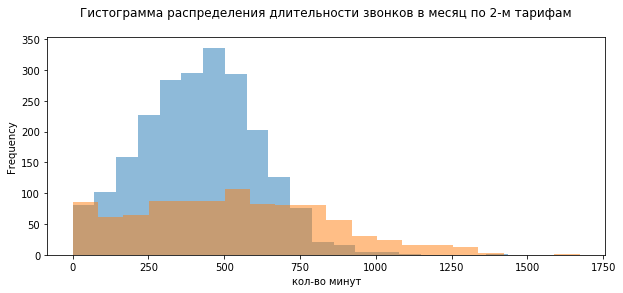

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [40]:
tariff_compare('minutes',
          'hist',
          'кол-во минут',
          'Гистограмма распределения длительности звонков в месяц по 2-м тарифам'+ "\n")

display(tariffs)

Примерно 2/3 пользоватеелй тарифа "Smart" укладываются в пакетный лимит размером 550 минут. И чаще всего они говорят именно столько. <br>

Однако видно, что примерно треть клиентов часто выходит за лимит, а значит переплачивает. Скорее всего не всем клиентам этого тарифа хватает предложенного кол-ва минут. Обычно им не хватает 200-300 минут.

Распределение минут у тарифа "Ultra" более широкое: манера звонить у абонентов этого тарифа более разнообразна, но они не выходят за рамки тарифа.

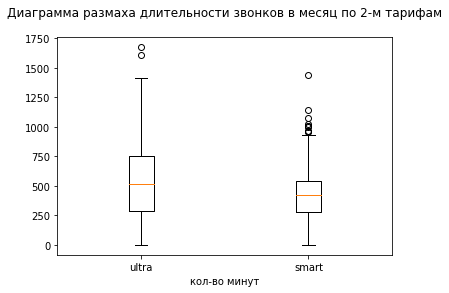

In [41]:
tariff_compare('minutes',
          'box',
          'кол-во минут',
          'Диаграмма размаха длительности звонков в месяц по 2-м тарифам'+ "\n")

По гистограмме и ящикам с усами видно, что пользователи тарифа "Smart" в среднем тратят меньше минут на звонки, чем пользователи тарифа "Ultra": 418 минут против 526. <br>

При этом распределение у тарифа "Ultra" более широкое а стандартное отклонения в 1,5 раза выше, чем у пользователей "Smart".<br>
Многие пользователи этого тарифа звонят либо гораздо больше, либо гораздо меньше, чем среднее значение, но при этом не выходят за лимит. <br>

<Figure size 720x216 with 0 Axes>

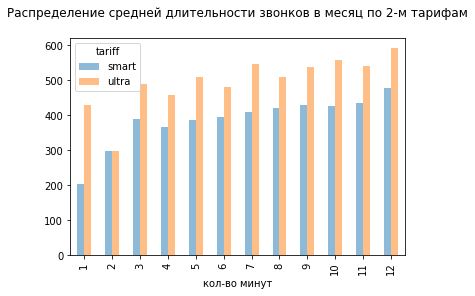

In [42]:
buildhist(minutes_mean,
          'bar',
          'кол-во минут',
          'Распределение средней длительности звонков в месяц по 2-м тарифам'+ "\n")

В течение года абоненты обоих тарифов увеличивают среднюю продолжительность разговоров. <br>

У абонентов тарифа "Smart" рост плавный и однородный, а у пользователей другого тарифа средня продолжительность хоть и растет, но колеблется от месяца к месяцу. <br>

Примечательно, что в феврале пользователи тарифа "Ultra" проговорили меньше всего минут.

### Изучаем среднее кол-во сообщений в месяц

In [43]:
messages_comp = report.groupby(by = 'tariff').agg({'messages': ['mean', 'std', 'var']})
messages_comp

messages                
           mean    std      var
tariff                         
smart     33.38  28.23   796.81
ultra     49.36  47.80  2285.27

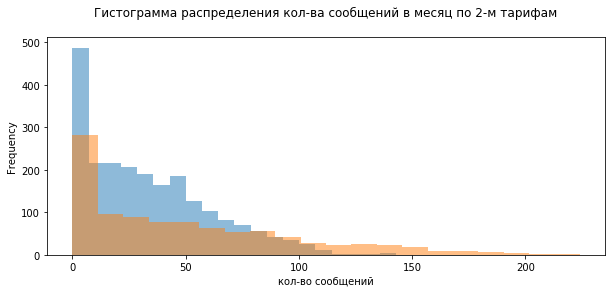

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [44]:
tariff_compare('messages',
          'hist',
          'кол-во сообщений',
          'Гистограмма распределения кол-ва сообщений в месяц по 2-м тарифам'+ "\n")

display(tariffs)

Пользователи обоих тарифов в основном отправляют до 50 сообщений в месяц. <br>
Однако заметная часть пользователей тарифа "Smart" выходит за этот лимит и платит за каждое дополнительное СМС сверх абонентской платы. Кажется, что некоторым из них обычно не хвает 100-120 сообщений.

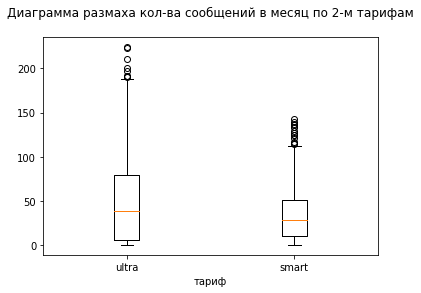

In [45]:
tariff_compare('messages',
          'box',
          'тариф',
          'Диаграмма размаха кол-ва сообщений в месяц по 2-м тарифам'+ "\n")

В среднем абоненты тарифа "Ultra" отправляют yf 16 сообщений больше, чем абоненты тарифа "Smart". <br>
При этом абоненты тарифа "Smart" более сдержаны, по сравнению с абонентами тарифа "Ultra": судя по размаху и дисперсии, кол-во отправленных сообщений сильно меняется от месяца к месяцу.

<Figure size 720x216 with 0 Axes>

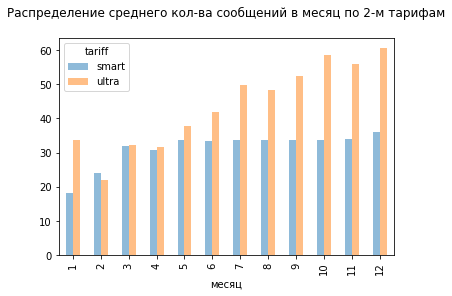

In [46]:
buildhist(messages_mean,
          'bar',
          'месяц',
          'Распределение среднего кол-ва сообщений в месяц по 2-м тарифам'+ "\n")

Действительно: кол-во отправленных сообщений у абонентов "Ultra" растет от месяца к месяцу, в то время как кол-во сообщений абонентов тарифа "Smart" после нескольких месяцев роста остается на одном уровне.

#### Выводы о различии использования сообщений в разных тарифах

### Изучаем среднее кол-во мегабайт в месяц

In [47]:
mb_comp = report.groupby(by = 'tariff').agg({'mb_used': ['mean', 'std', 'var']})
mb_comp

mb_used                      
            mean      std          var
tariff                                
smart   16150.31  5853.57  34264251.57
ultra   19012.61  9841.69  96858860.77

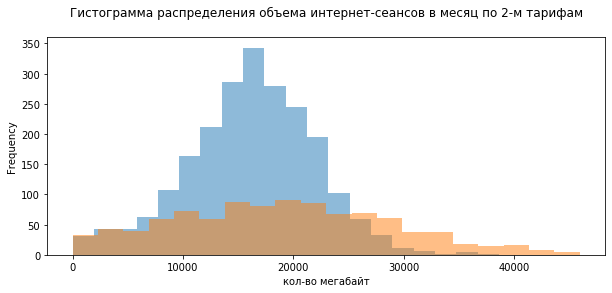

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [48]:
tariff_compare('mb_used',
          'hist',
          'кол-во мегабайт',
          'Гистограмма распределения объема интернет-сеансов в месяц по 2-м тарифам'+ "\n")

display(tariffs)

Гистограмма распределения использования интернет-трафика достаточно интересная: больше половины всех пользователей тарифа "Smart" не укладываются в лимит 15360 МБ. Значит, больше всего пользователи этого тарифа переплачивают именно за интернет. <br>

Пользователи тарифа "Ultra" тоже переплачивают за интернет, так как выходят за лимит. Но это характерно чуть менее чем для четверти пользователей.

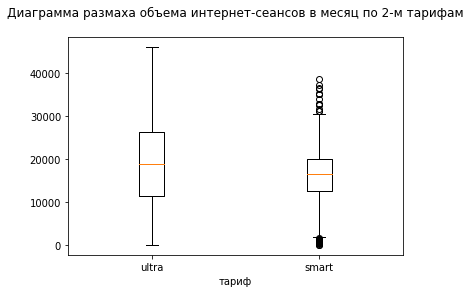

In [49]:
tariff_compare('mb_used',
          'box',
          'тариф',
          'Диаграмма размаха объема интернет-сеансов в месяц по 2-м тарифам'+ "\n")

В среднем пользователи тарифа "Ultra" тратят больше трафика, чем пользователи тарифа "Smart". <br>
Разброс значений у этого тарифа тоже больше. <br>
Пользователи тарифа "Smart" не так сильно отклоняются от среднего значения. Однако отклонения в большую сторону от среднего значительно превышают месячный лимит интернет-трафика.

<Figure size 720x216 with 0 Axes>

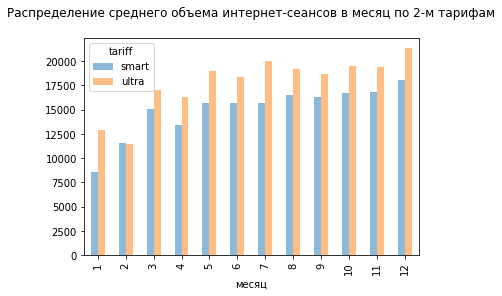

In [50]:
buildhist(mb_mean,
          'bar',
          'месяц',
          'Распределение среднего объема интернет-сеансов в месяц по 2-м тарифам'+ "\n")

Расход трафика растет у пользователей обоих тарифов в течение года. <br>
У пользователей "Ultra" рост нелинейный и более хаотичный, чем у пользователей тарифа "Smart" (у них он стабильный).

### Изучаем среднюю выручку по тарифам в месяц

По анализу трат не совсем понятно, вложения в рекламу какого тарифу смогут принести большую отдачу. <br>
Для этого важно изучить выручку.

In [51]:
revenue_comp = report.groupby(by = 'tariff').agg({'revenue': ['mean', 'std', 'var']})
revenue_comp.T

tariff            smart      ultra
revenue mean    1282.62    2051.88
        std      813.50     334.41
        var   661785.56  111828.28

In [52]:
# вспомним абонентсткую плату по каждому тарифу
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Видно, что пользователи тарифа "Smart" в среднем переплачивают почти в 2,5 раза. Значит, они часто выходят за лимиты и готовы за это платить. <br>
Пользователи тарифа "Ultra" в среднем переплачивают всего на 100 рублей. Значит им хватает предложенного пакета минут, мегабайт и сообщений и они не приносят компании дополнительной прибыли сверх абонентской платы.

In [69]:
print('кол-во абонентов Smart:', len(report.query('tariff == "smart"').groupby(by = 'user_id')))
print('кол-во абонентов Ultra:', len(report.query('tariff == "ultra"').groupby(by = 'user_id')))

кол-во абонентов Smart: 350
кол-во абонентов Ultra: 148


При условии, что пользователей тарифа "Smart" в 2 раза больше, чем пользователей тарифа "Ultra, и они в среднем переплачивают в 2,5 раза, можно заключить, что они принесут оператору больше прибыли.

**Однако мы не можем судить о кол-во абонентов, так как у нас есть только небольшая выборка.** <br>
**Чтобы вывод был логичен, нужно точно знать распределение абонентов оператора по тарифам.**

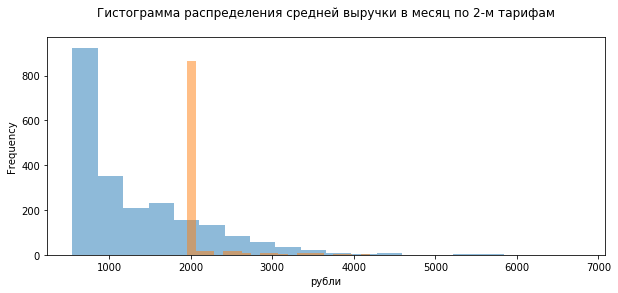

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [55]:
tariff_compare('revenue',
          'hist',
          'рубли',
          'Гистограмма распределения средней выручки в месяц по 2-м тарифам'+ "\n")

display(tariffs)

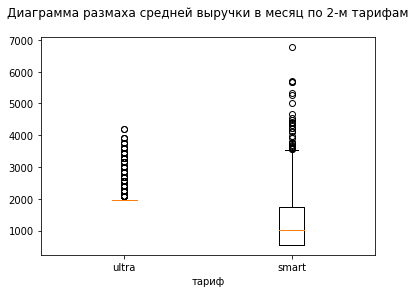

In [56]:
tariff_compare('revenue',
          'box',
          'тариф',
          'Диаграмма размаха средней выручки в месяц по 2-м тарифам'+ "\n")

По графикам распределения также видно, что разброс расходов у пользователей тарифа "Smart" гораздо шире. <br>
У абонентов "Ultra" его практически нет, судя по диаграмме размаха. <br>
Изучим распределение расходов отдельно у каждого тарифа.

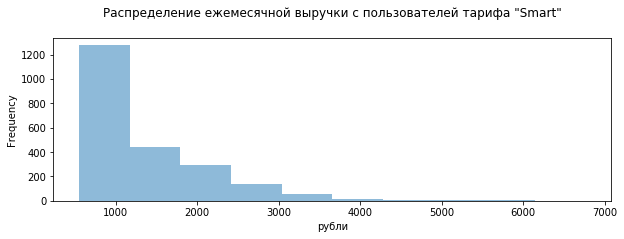

count    2229.00
mean     1282.62
std       813.50
min       550.00
25%       550.00
50%      1014.00
75%      1750.00
max      6770.00
Name: revenue, dtype: float64

In [57]:
buildhist(report.query('tariff == "smart"').revenue,
          'hist',
          'рубли',
          'Распределение ежемесячной выручки с пользователей тарифа "Smart"'+ "\n")
report.query('tariff == "smart"').revenue.describe()

У тарифа "Smart" видно широкое распределение с длинным хвостом до 7 тысяч рублей. <br>
Половина всех абонентов платит практически в два раза больше стоимости абонентсткой платы. <br>
А максимальная выручка за год составила 6770 рублей, что в 12 раз выше абонентсткой платы!

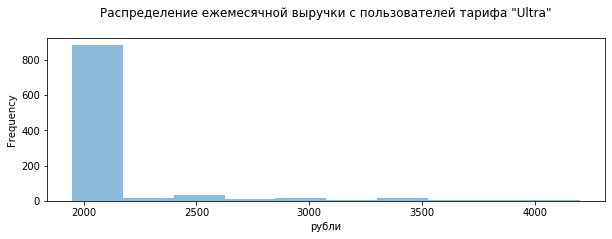

count     985.00
mean     2051.88
std       334.41
min      1950.00
25%      1950.00
50%      1950.00
75%      1950.00
max      4200.00
Name: revenue, dtype: float64

In [58]:
buildhist(report.query('tariff == "ultra"').revenue,
          'hist',
          'рубли',
          'Распределение ежемесячной выручки с пользователей тарифа "Ultra"'+ "\n")
report.query('tariff == "ultra"').revenue.describe()

Все расходы сосредоточены вокруг среднего значения, которое близко к фактической стоимости обслуживания. <br>
3/4 всех пользователей тарифа укладываются в абонентскую плату и лишь четверть незначительно переплачивает. <br>
Максимальные расходы у абонентов этого тарифа ниже на 2,5 тысячи рублей.

Описание графика

<Figure size 720x216 with 0 Axes>

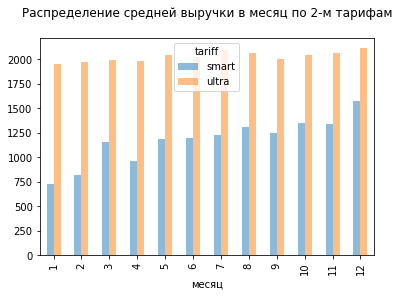

In [59]:
buildhist(revenue_mean,
          'bar',
          'месяц',
          'Распределение средней выручки в месяц по 2-м тарифам'+ "\n")

По графику видно, что расходы у пользователей тарифа "Smart" растут: к концу года средняя выручка стала в 2 раза выше, чем в начале года. <br>
Средняя выручка абонентов "Ultra" в течение года находится примерно на одном уровне.

Выведем общую таблицу для наглядного сравнения.

In [60]:
# вспомним абонентсткую плату по каждому тарифу
display(tariffs)

# и выведем таблицу для сравнения разных тарифов
final_comp = revenue_comp.merge(minutes_comp, how='left', on='tariff')
final_comp = final_comp.merge(mb_comp, how='left', on='tariff')
final_comp = final_comp.merge(messages_comp, how='left', on='tariff')
display(final_comp.T)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


tariff               smart        ultra
revenue  mean      1282.62      2051.88
         std        813.50       334.41
         var     661785.56    111828.28
minutes  mean       417.93       526.62
         std        190.31       317.61
         var      36219.32    100873.63
mb_used  mean     16150.31     19012.61
         std       5853.57      9841.69
         var   34264251.57  96858860.77
messages mean        33.38        49.36
         std         28.23        47.80
         var        796.81      2285.27

### Общий вывод а различии между абонентами разных тарифов <a id="conclusion3"></a>
[В начало шага](#Шаг_3)

Анализ распределения средних значений показывает, что пользователи разных тарифных планов отличаются в своем потреблении услуг связи.

Пользователи тарифа "Ultra" расходуют тарифные пакеты более разнообразно, но их лимиты такие высокие, что большинство клиентов за них не выходят (а те, кто выходят, доплачивают незначительные суммы).

Пользователи тарифа "Smart" платят и расходуют в среднем меньше, но часто перерасходуют пакеты минут и мегабайт и поэтому переплачивают.

***

## Шаг 4. Проверка гипотез <a id="Шаг_4"></a>
[В начало проекта](#заголовок) <br>
[К выводам по шагу](#conclusion4)

Чек-лист:
- [x] проверена гипотеза "средняя выручка пользователей тарифов «Ультра» и «Смарт» различается"
- [x] проверена гипотеза "средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов"
- [x] есть пояснение, как формулировали нулевую и альтернативные гипотезы
- [x] есть пояснение, какой критерий использовали для проверки гипотез и почему

<br>
Для проверки гипотез будем использовать метод сравнения двух выборочных средних для разных выборок (T-test) и критерий p-value. <br>
P-value — вероятность получить данный исход события при условии, что нулевая гипотеза верна. <br>
Если это значение ниже выбранного уровня значимости, то вероятность получить такой исход при истинности нулевой гипотезы крайне мала, а значит такой исход не случаен и нулевую гипотезу можно отвергнуть, т.к. она не может быть истинной.<br>

Уровнем статистической значимости теста выберем 5% или 0.05. <br>
Значит, если p-value будет ниже этого уровня, мы сможем отвергнуть нулевую гипотезу и наоборот.

### Проверяем гипотезу о различии средней выручки у пользователей разных тарифов
<br>

**Нулевая гипотеза:** средняя выручка у пользователей разных тарифов не различается <br>
**Альтернативная гипотеза:** средняя выручка различается у пользователей разных тарифов

In [61]:
sample_1 = report.query('tariff == "smart"').revenue
sample_2 = report.query('tariff == "ultra"').revenue
results = st.ttest_ind(sample_1, sample_2)
alpha = 0.05

print('p-value:', results.pvalue)
print()
if results.pvalue < alpha:
    print('Принимаем альтернативную гипотезу: средняя выручка с пользователей разных тарифов различается')
else:
    print('Опровергнуть нулевую гипотезу нельзя: различие может быть случайным')

p-value: 1.0026039952951318e-160

Принимаем альтернативную гипотезу: средняя выручка с пользователей разных тарифов различается


### Проверяем гипотезу о различии средней выручки у пользователей из Москвы и регионов
<br>

**Нулевая гипотеза:** средняя выручка у пользователей из Москвы и регионов не различается <br>
**Альтернативная гипотеза:** средняя выручка различается у пользователей из Москвы и других регионов

In [62]:
sample_1 = report.query('city == "Москва"').revenue
sample_2 = report.query('city != "Москва"').revenue
results = st.ttest_ind(sample_1, sample_2)
alpha = 0.05

print('p-value: ', results.pvalue)
print()
if results.pvalue < alpha:
    print('Принимаем альтернативную гипотезу: средняя выручка с пользователей Москвы и регионов различается')
else:
    print('Опровергнуть нулевую гипотезу нельзя: различие может быть случайным')

p-value:  0.546104262530761

Опровергнуть нулевую гипотезу нельзя: различие может быть случайным


### Выводы <a id="conclusion4"></a>
[В начало шага](#Шаг_4)

Различие  средней выручки с разных тарифов неслучайно. <br>
Средняя выручка с пользователей тарифа "Ultra" действительно выше, чем выручка с пользователей тарифа "Smart".

А вот точно сказать, есть ли разница между средней выручкой в Москве и средней выручкой в регионах мы не можем. <br>
Слишком высока вероятность, что полученная разница случайна. А значит, вполне вероятно, что такой разницы может и не быть.

## Шаг 5. Выводы по итогам исследования <a id="Шаг_5"></a>
[В начало проекта](#заголовок) <br>

Пользователи тарифа "Smart" в среднем используют меньше минут, мегабайт и сообщений, чем пользователи тарифа "Ultra". <br>
Также средняя выручка с пользователей этого тарифа примерно на 800 рублей меньше, чем с пользователей тарифа "Ultra". <br>

Тем не менее эти пользователи переплачивают за свой тариф почти в 2,5 раза, в то время как пользователи "Ultra" переплачивают незначительно. <br>
Это происходит потому, что использование услуг связи у пользователей тарифа "smart" более разнообразно: <br>
от месяца к месяцу они используют все больше минут и мегабайт, что приводит к превышению лимитов по тарифу и большому объему дополнительной выручки для оператора.<br>
В основном абоненты этого тарифа переплачивают за интернет: половине из них не достаточно 15ГБ в месяц.
<br>

Абоненты тарифа "Ultra" обычно укладываются в лимиты и не приносят оператору такого объема дополнительной выручки.

Если тариф "Smart" более популярен, то за счет увеличения кол-ва абонентов этого тарифа оператор может увеличить общую выручку. <br>
**В таком случае оператору будет выгоднее перераспределить рекламный бюджет в пользу тарифа "Smart" и сохранить тарифные лимиты.**

Если же тариф "Ultra" более популярен (его покупают охотнее), то для увеличения выручки следует перераспределить рекламный бюджет в его пользу.